# Importing libs and database files 

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import pingouin as pg
import seaborn as sns
from modules import analysis
from itertools import combinations
import scikit_posthocs as sp

# Importing Data

In [28]:
# importint a csv file.
df_gklab = pd.read_csv('/home/victormoraes/MEGA/Archive/PhD IBCCF-UFRJ/PhD/EMT no Jogo do goleiro/Data processing/data_TMS-GKg/Processed_data/2025-11-18/df_gklab_analysis_20251118_worstSubGroup.csv')

# Fix the type of the 'context' column
df_gklab['context'] = df_gklab['context'].astype(pd.Int64Dtype())
df_gklab['context'] = df_gklab['context'].astype(str)
df_gklab['context'] = df_gklab['context'].replace('0', '00')

# Exclude volunteers if needed

In [29]:
lst_excluded_volunteers = []

df_gklab = df_gklab[~df_gklab['ID_info'].isin(lst_excluded_volunteers)]

# Success Rate Analysis
- Normality test
- Kruskal-Wallis test and Dunn's post hoc with Benjamini/Hochberg correction 

         W   pval  normal
1.0  0.907  0.378    True
2.0  0.772  0.021   False
3.0  0.894  0.296    True
4.0  0.915  0.430    True
5.0  0.957  0.791    True
6.0  0.940  0.640    True


/home/victormoraes/Documents/GitHub/TMS-GoalkeeperGame/modules/analysis.py:125: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  success_rates = group.groupby('block_info').apply(
/home/victormoraes/Documents/GitHub/TMS-GoalkeeperGame/modules/analysis.py:125: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  success_rates = group.groupby('block_info').apply(
/home/victormoraes/Documents/GitHub/TMS-GoalkeeperGame/modules/ana

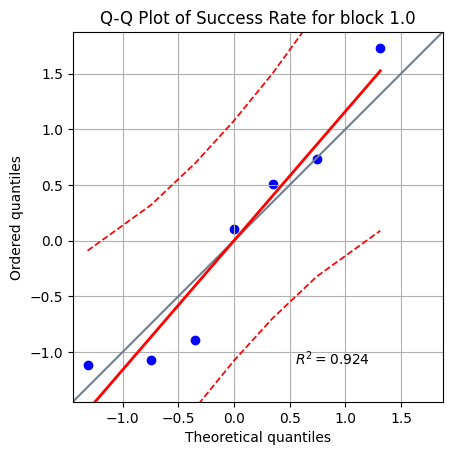

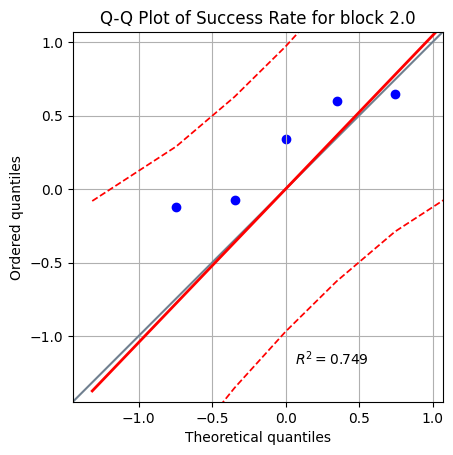

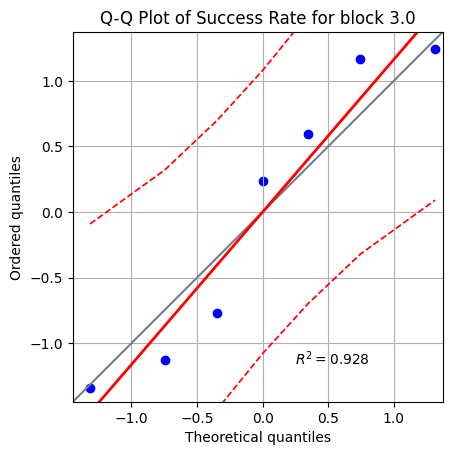

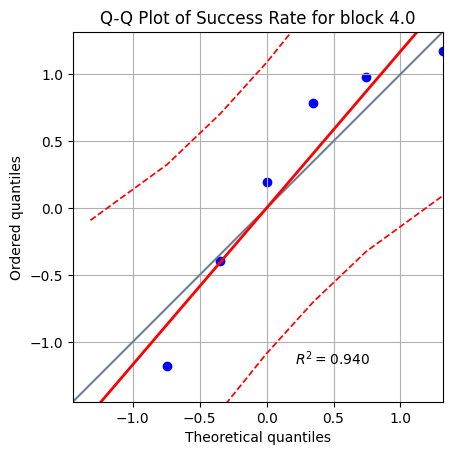

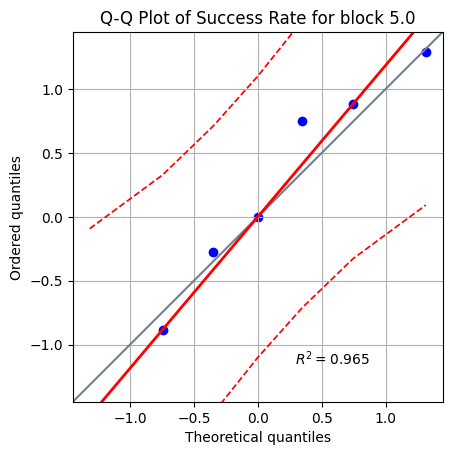

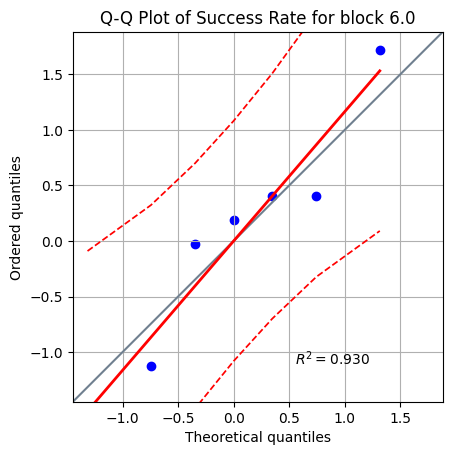

In [30]:
# Calculating mean values of subjects
success_rate_blocks = analysis.calculate_success_rate_by_block_group(df_gklab)

# Convert the dictionary to a DataFrame
success_rate_blocks_df = pd.DataFrame.from_dict(success_rate_blocks, orient='index')

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(success_rate_blocks_df)
print(shapiro_results.round(3))

# Q-Q plots for each block
for column in success_rate_blocks_df.columns:
    plt.figure()  # Create a new figure for each column
    pg.qqplot(success_rate_blocks_df[column], dist='norm')
    plt.title(f'Q-Q Plot of Success Rate for block {column}')
    plt.grid(True)
    plt.show()

# # Histograms for each block
# for column in success_rate_blocks_df.columns:
#     plt.figure()  # Create a new figure for each column
#     sns.histplot(success_rate_blocks_df[column], kde=True)
#     plt.title(f'Histogram of Success Rate for block {column}')
#     plt.xlabel('Success Rate')
#     plt.ylabel('Frequency')
#     plt.show()

In [31]:
# Convert wide format to long format
success_rate_blocks_df = success_rate_blocks_df.melt(var_name='Block', value_name='SuccessRate')

# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=success_rate_blocks_df, 
                          dv='SuccessRate', 
                          between='Block')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = success_rate_blocks_df['Block'].nunique()
n = len(success_rate_blocks_df)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(success_rate_blocks_df, val_col='SuccessRate', group_col='Block', p_adjust='fdr_bh') # Benjamini/Hochberg (non-negative) ‘fdr_bh’
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results.round(3))
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
        Source  ddof1      H  p-unc
Kruskal  Block      5  15.22  0.009

Eta ao quadrado adaptado (η²) para Kruskal-Wallis: 0.2839

Dunn's Post Hoc Test Results:
       1.0    2.0    3.0    4.0    5.0    6.0
1.0  1.000  0.668  0.223  0.042  0.043  0.042
2.0  0.668  1.000  0.431  0.095  0.112  0.074
3.0  0.223  0.431  1.000  0.421  0.431  0.344
4.0  0.042  0.095  0.421  1.000  0.887  0.887
5.0  0.043  0.112  0.431  0.887  1.000  0.858
6.0  0.042  0.074  0.344  0.887  0.858  1.000


# Response Time in different Buttons Analysis
- Normality and Homocedasticity Tests
- ANOVA one way

                   W   pval  normal
response_info                      
0.0            0.860  0.152    True
1.0            0.972  0.913    True
2.0            0.935  0.594    True


            W  pval  equal_var
levene  0.073  0.93       True


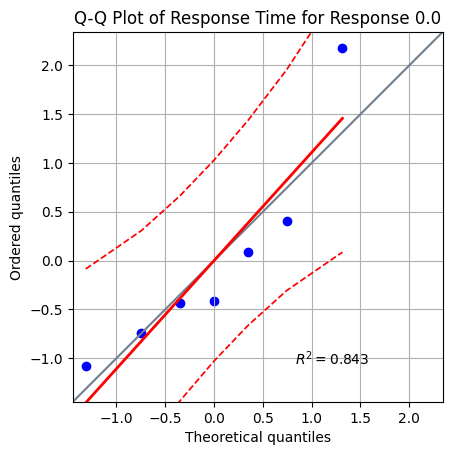

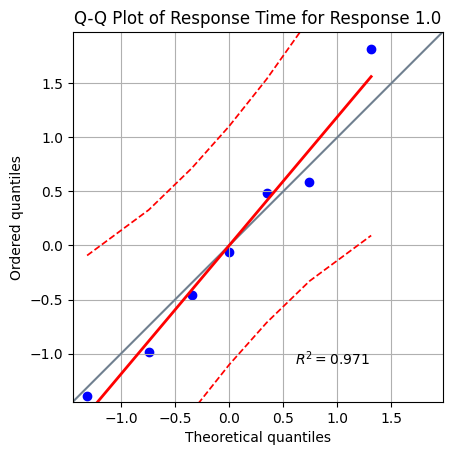

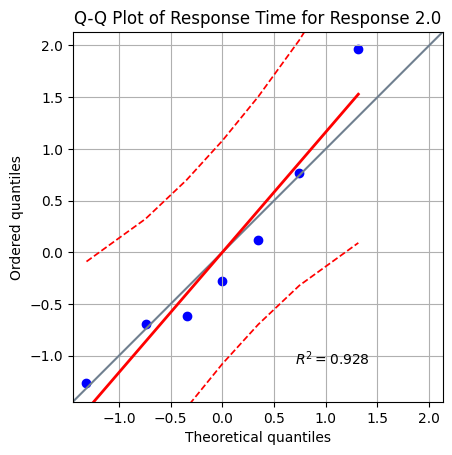

In [32]:
# Calculate mean response times grouped by ID_info and response_info and plot RTs by Responses
mean_response_times_by_responses = df_gklab.groupby(['ID_info', 'response_info'])['response_time_info'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_response_times_by_responses, dv='response_time_info', group='response_info')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_response_times_by_responses, dv='response_time_info', group='response_info')
print(levene_results.round(3))

# Q-Q plots for each response category
response_categories = mean_response_times_by_responses['response_info'].unique()
for response in response_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_response_times_by_responses[mean_response_times_by_responses['response_info'] == response]['response_time_info'], dist='norm')
    plt.title(f'Q-Q Plot of Response Time for Response {response}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for response in response_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_response_times_by_responses[mean_response_times_by_responses['response_info'] == response]['response_time_info'], kde=True)
#     plt.title(f'Histogram of Response Time for Response {response}')
#     plt.xlabel('Response Time')
#     plt.ylabel('Frequency')
#     plt.show()

In [33]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_response_times_by_responses, dv='response_time_info', between='response_info', detailed=True)

# Print the ANOVA results
print(anova_results.round(3))

          Source     SS  DF     MS      F  p-unc    np2
0  response_info  0.016   2  0.008  0.568  0.576  0.059
1         Within  0.250  18  0.014    NaN    NaN    NaN


In [34]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_response_times_by_responses, 
                          dv='response_time_info', 
                          between='response_info')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_response_times_by_responses, val_col='response_time_info', group_col='response_info', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results.round(3))
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
                Source  ddof1      H  p-unc
Kruskal  response_info      2  0.987   0.61

No significant differences found; no post hoc analysis needed.


# Response Time by Blocks Analysis
- Normality test
- Kruskal-Wallis test and Dunn's post hoc with Benjamini/Hochberg correction 

                W   pval  normal
block_info                      
1.0         0.939  0.631    True
2.0         0.898  0.320    True
3.0         0.827  0.075    True
4.0         0.902  0.345    True
5.0         0.926  0.514    True
6.0         0.943  0.667    True


            W   pval  equal_var
levene  0.199  0.961       True


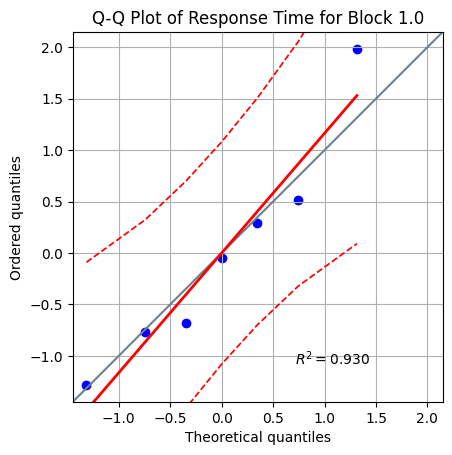

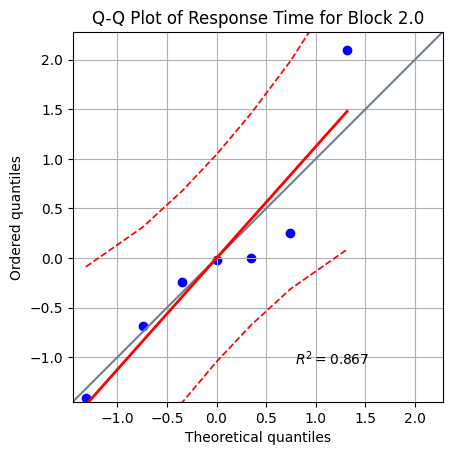

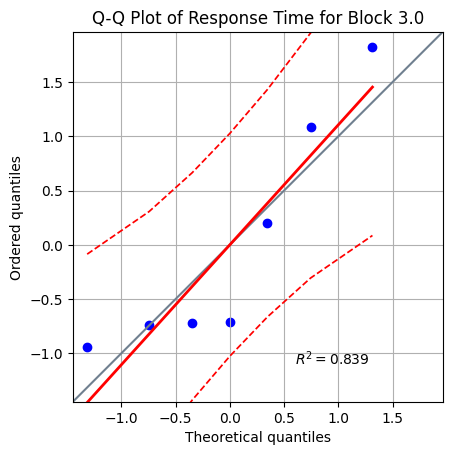

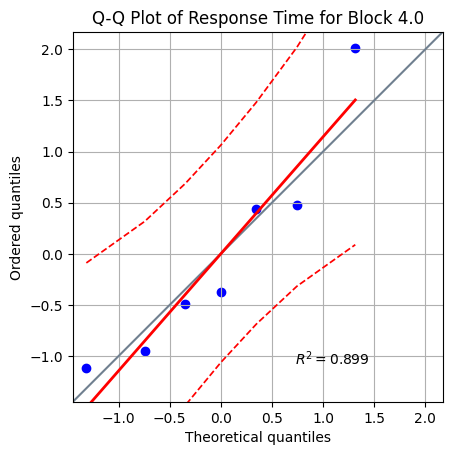

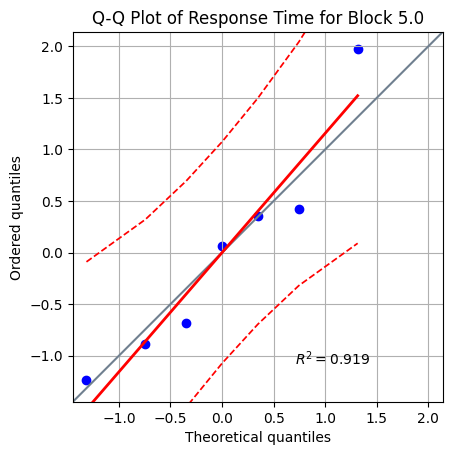

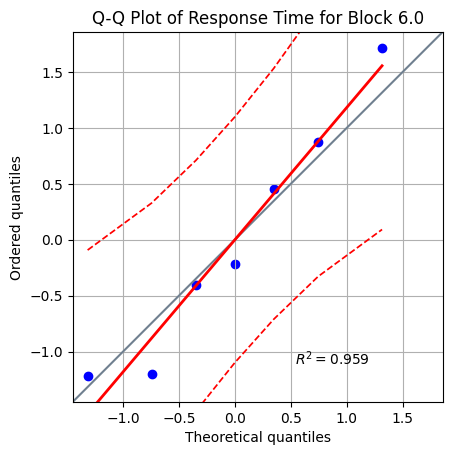

In [35]:
# Calculate mean response times grouped by ID_info and block_info and plot RTs by Blocks
mean_response_times_by_blocks = df_gklab.groupby(['ID_info', 'block_info'])['response_time_info'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_response_times_by_blocks, dv='response_time_info', group='block_info')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_response_times_by_blocks, dv='response_time_info', group='block_info')
print(levene_results.round(3))

# Q-Q plots for each response category
block_categories = mean_response_times_by_blocks['block_info'].unique()
for block in block_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_response_times_by_blocks[mean_response_times_by_blocks['block_info'] == block]['response_time_info'], dist='norm')
    plt.title(f'Q-Q Plot of Response Time for Block {block}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for block in block_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_response_times_by_blocks[mean_response_times_by_blocks['block_info'] == block]['response_time_info'], kde=True)
#     plt.title(f'Histogram of Response Time for Block {block}')
#     plt.xlabel('Response Time')
#     plt.ylabel('Frequency')
#     plt.show()

In [36]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_response_times_by_blocks, 
                          dv='response_time_info', 
                          between='block_info')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_response_times_by_blocks['block_info'].nunique()
n = len(mean_response_times_by_blocks)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_response_times_by_blocks, val_col='response_time_info', group_col='block_info', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results.round(3))
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
             Source  ddof1      H  p-unc
Kruskal  block_info      5  8.476  0.132

Eta ao quadrado adaptado (η²) para Kruskal-Wallis: 0.0966

No significant differences found; no post hoc analysis needed.


In [37]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_response_times_by_blocks, dv='response_time_info', between='block_info', detailed=True)

# Print the ANOVA results
print(anova_results)
print("\n")

# Run post hoc tests if ANOVA is significant
if anova_results['p-unc'].values[0] < 0.05:
    posthoc_results = pg.pairwise_tests(data=mean_response_times_by_blocks, 
                                         dv='response_time_info', 
                                         between='block_info', 
                                         padjust='fdr_bh')
    print(posthoc_results)
    
else:
    print("No significant differences found; no post hoc analysis needed.")

       Source        SS  DF        MS         F     p-unc       np2
0  block_info  0.133145   5  0.026629  1.746869  0.148957  0.195249
1      Within  0.548780  36  0.015244       NaN       NaN       NaN


No significant differences found; no post hoc analysis needed.


# Response times with and without TMS pulses
- Normality test
- Unpaired T test

               W   pval  normal
tms_pulse                      
Pulse      0.929  0.545    True
noPulse    0.884  0.247    True


            W   pval  equal_var
levene  0.126  0.729       True


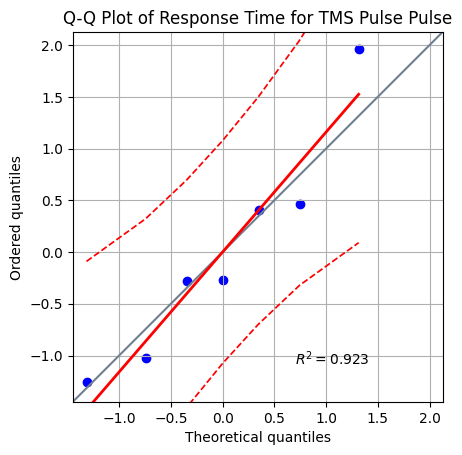

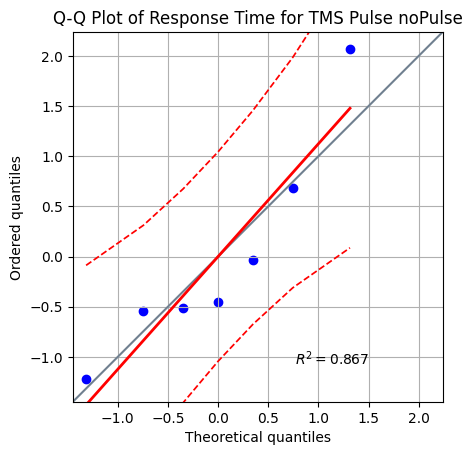

In [38]:
# Calculate mean response times grouped by ID_info and TMS pulse
mean_response_times_NoPulse_Pulse = df_gklab.groupby(['ID_info', 'tms_pulse'])['response_time_info'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_response_times_NoPulse_Pulse, dv='response_time_info', group='tms_pulse')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_response_times_NoPulse_Pulse, dv='response_time_info', group='tms_pulse')
print(levene_results.round(3))

# Q-Q plots for each response category
pulse_categories = mean_response_times_NoPulse_Pulse['tms_pulse'].unique()
for i in pulse_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_response_times_NoPulse_Pulse[mean_response_times_NoPulse_Pulse['tms_pulse'] == i]['response_time_info'], dist='norm')
    plt.title(f'Q-Q Plot of Response Time for TMS Pulse {i}')
    plt.grid(True)
    plt.show()
    
# # Histograms for each response category
# for i in pulse_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_response_times_NoPulse_Pulse[mean_response_times_NoPulse_Pulse['tms_pulse'] == i]['response_time_info'], kde=True)
#     plt.title(f'Histogram of Response Time for TMS Pulse {i}')
#     plt.xlabel('Response Time')
#     plt.ylabel('Frequency')
#     plt.show()

In [39]:
# Get x and y from dataframe
rt_with_tms = mean_response_times_NoPulse_Pulse[mean_response_times_NoPulse_Pulse['tms_pulse'] == 'Pulse']['response_time_info']
rt_without_tms = mean_response_times_NoPulse_Pulse[mean_response_times_NoPulse_Pulse['tms_pulse'] == 'noPulse']['response_time_info']

# Perform T test
ttest_results = pg.ttest(rt_with_tms, rt_without_tms, correction=False, paired=False)
print(ttest_results.round(3))

            T  dof alternative  p-val          CI95%  cohen-d   BF10  power
T-test -1.249   12   two-sided  0.235  [-0.21, 0.06]    0.668  0.733   0.21


# Response Time by Contexts during TMS pulses
- Normality test
- ANOVA with pairwise T tests and Benjamini/Hochberg correction

                W      pval  normal
context                            
00       0.990431  0.993986    True
1        0.915806  0.437529    True
10       0.908545  0.385890    True
2        0.887129  0.260019    True
20       0.950791  0.736893    True


               W      pval  equal_var
levene  0.152523  0.960389       True


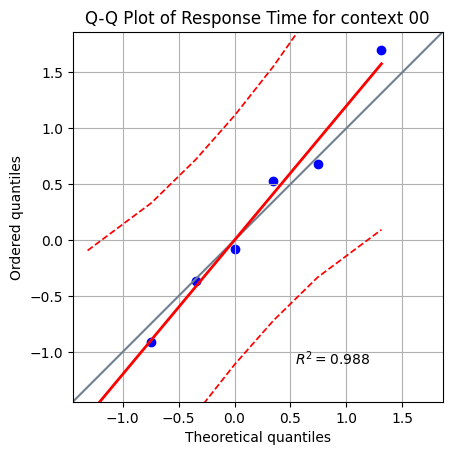

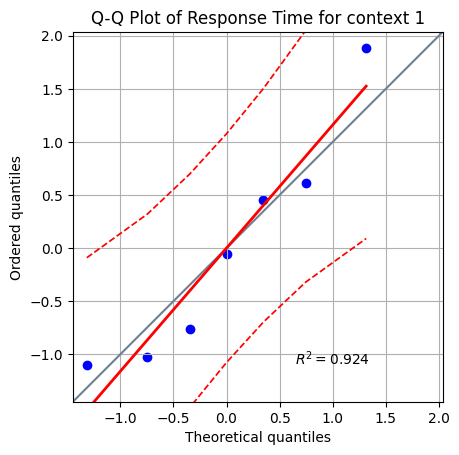

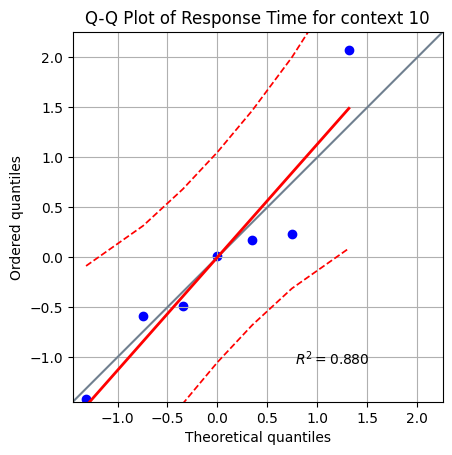

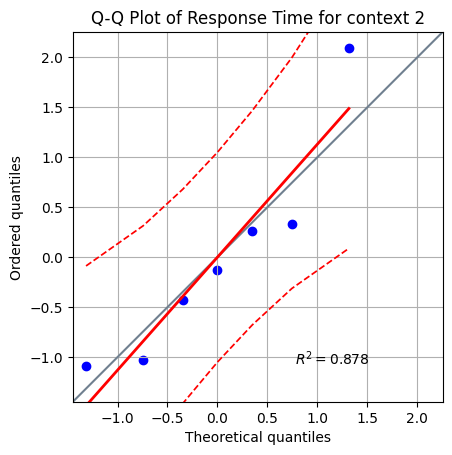

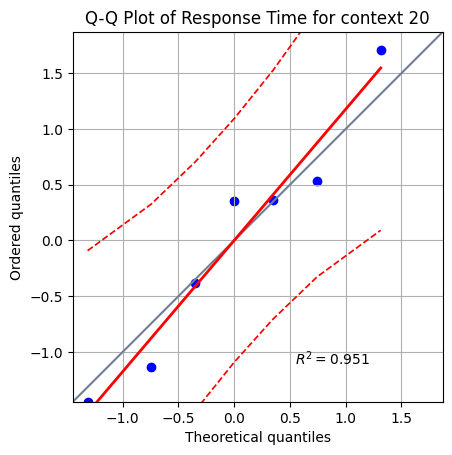

In [40]:
# Filter RTs during pulses
rt_pulse_df = df_gklab.loc[(df_gklab['tms_pulse'] == 'Pulse') & (df_gklab['context'] != '<NA>')]

# Get Mean Response Times by Contexts and Plot   
mean_response_times_pulse_ctx = rt_pulse_df.groupby(['ID_info', 'context'])['response_time_info'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_response_times_pulse_ctx, dv='response_time_info', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_response_times_pulse_ctx, dv='response_time_info', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = mean_response_times_pulse_ctx['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_response_times_pulse_ctx[mean_response_times_pulse_ctx['context'] == i]['response_time_info'], dist='norm')
    plt.title(f'Q-Q Plot of Response Time for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_response_times_pulse_ctx[mean_response_times_pulse_ctx['context'] == i]['response_time_info'], kde=True)
#     plt.title(f'Histogram of Response Time for context {i}')
#     plt.xlabel('Response Time')
#     plt.ylabel('Frequency')
#     plt.show()

In [41]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_response_times_pulse_ctx, dv='response_time_info', between='context', detailed=True)

# Print the ANOVA results
print(anova_results)
print("\n")

# Run post hoc tests if ANOVA is significant
if anova_results['p-unc'].values[0] < 0.05:
    posthoc_results = pg.pairwise_tests(data=mean_response_times_pulse_ctx, 
                                         dv='response_time_info', 
                                         between='context', 
                                         padjust='fdr_bh')
    print(posthoc_results)
    
else:
    print("No significant differences found; no post hoc analysis needed.")

    Source        SS  DF        MS         F     p-unc      np2
0  context  0.013858   4  0.003465  0.221848  0.924112  0.02873
1   Within  0.468511  30  0.015617       NaN       NaN      NaN


No significant differences found; no post hoc analysis needed.


In [42]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_response_times_pulse_ctx, 
                          dv='response_time_info', 
                          between='context')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_response_times_pulse_ctx['context'].nunique()
n = len(mean_response_times_pulse_ctx)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_response_times_pulse_ctx, val_col='response_time_info', group_col='context', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results.round(3))
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
          Source  ddof1      H  p-unc
Kruskal  context      4  1.053  0.902

Eta ao quadrado adaptado (η²) para Kruskal-Wallis: -0.0982

No significant differences found; no post hoc analysis needed.


# Response Time by Contexts without TMS pulses
- Normality test
- Kruskal-Wallis test and Dunn's post hoc with Benjamini/Hochberg correction 

                W      pval  normal
context                            
00       0.912506  0.413497    True
1        0.905414  0.365033    True
10       0.917480  0.450074    True
2        0.870254  0.186580    True
20       0.925247  0.511242    True


               W      pval  equal_var
levene  0.154955  0.959259       True


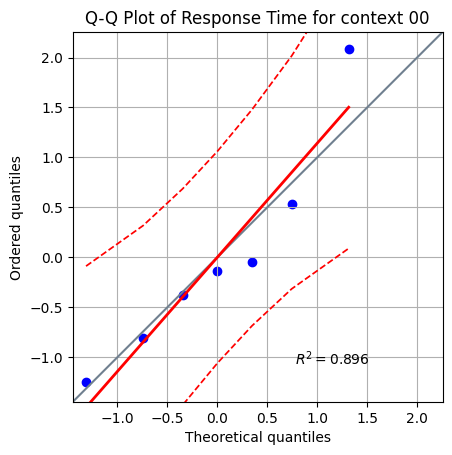

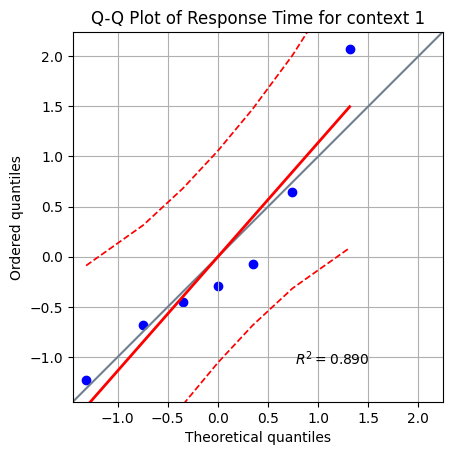

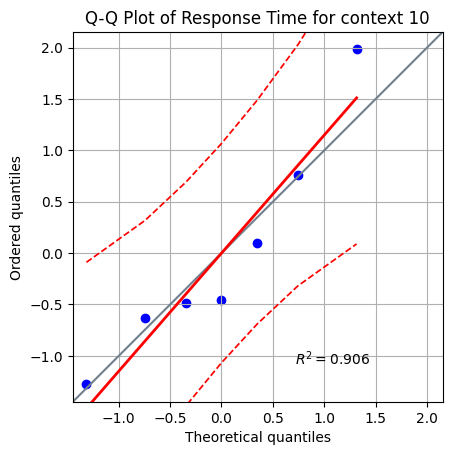

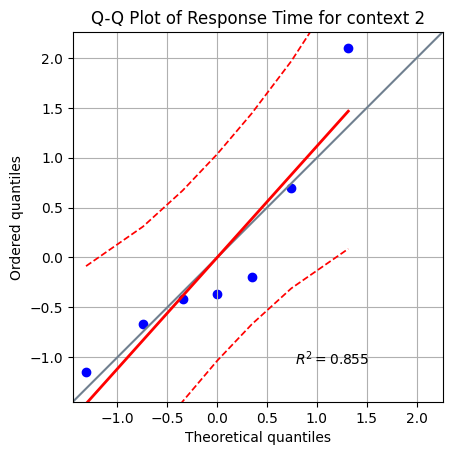

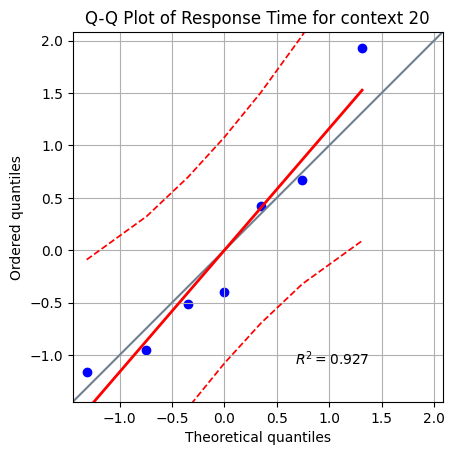

In [43]:
# Filter RTs during pulses
rt_nopulse_df = df_gklab.loc[(df_gklab['tms_pulse'] == 'noPulse') & (df_gklab['context'] != '<NA>')]

# Get Mean Response Times by Contexts and Plot   
mean_response_times_nopulse_ctx = rt_nopulse_df.groupby(['ID_info', 'context'])['response_time_info'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_response_times_nopulse_ctx, dv='response_time_info', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_response_times_nopulse_ctx, dv='response_time_info', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = mean_response_times_nopulse_ctx['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_response_times_nopulse_ctx[mean_response_times_nopulse_ctx['context'] == i]['response_time_info'], dist='norm')
    plt.title(f'Q-Q Plot of Response Time for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_response_times_nopulse_ctx[mean_response_times_nopulse_ctx['context'] == i]['response_time_info'], kde=True)
#     plt.title(f'Histogram of Response Time for context {i}')
#     plt.xlabel('Response Time')
#     plt.ylabel('Frequency')
#     plt.show()

In [44]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_response_times_nopulse_ctx, dv='response_time_info', between='context', detailed=True)

# Print the ANOVA results
print(anova_results)
print("\n")

# Run post hoc tests if ANOVA is significant
if anova_results['p-unc'].values[0] < 0.05:
    posthoc_results = pg.pairwise_tests(data=mean_response_times_nopulse_ctx, 
                                         dv='response_time_info', 
                                         between='context', 
                                         padjust='fdr_bh')
    print(posthoc_results)
    
else:
    print("No significant differences found; no post hoc analysis needed.")

    Source        SS  DF        MS         F    p-unc       np2
0  context  0.043377   4  0.010844  0.941121  0.45375  0.111492
1   Within  0.345684  30  0.011523       NaN      NaN       NaN


No significant differences found; no post hoc analysis needed.


In [45]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_response_times_nopulse_ctx, 
                          dv='response_time_info', 
                          between='context')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_response_times_nopulse_ctx['context'].nunique()
n = len(mean_response_times_nopulse_ctx)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_response_times_nopulse_ctx, val_col='response_time_info', group_col='context', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results.round(3))
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
          Source  ddof1      H  p-unc
Kruskal  context      4  4.101  0.393

Eta ao quadrado adaptado (η²) para Kruskal-Wallis: 0.0034

No significant differences found; no post hoc analysis needed.


# Response Time by Contexts with all RTs (n=1200)
- Normality test
- ANOVA with pairwise T test and Benjamini/Hochberg correction

             W   pval  normal
context                      
00       0.916  0.441    True
1        0.913  0.418    True
10       0.878  0.216    True
2        0.890  0.276    True
20       0.937  0.615    True


            W   pval  equal_var
levene  0.156  0.959       True


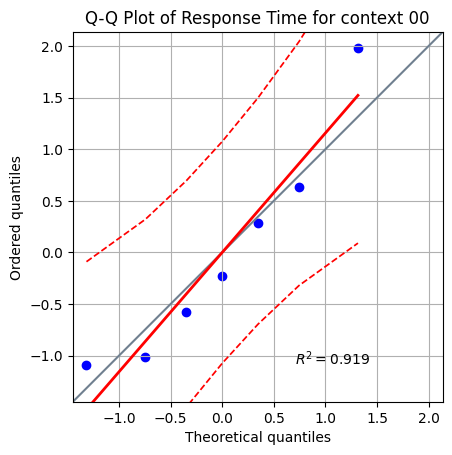

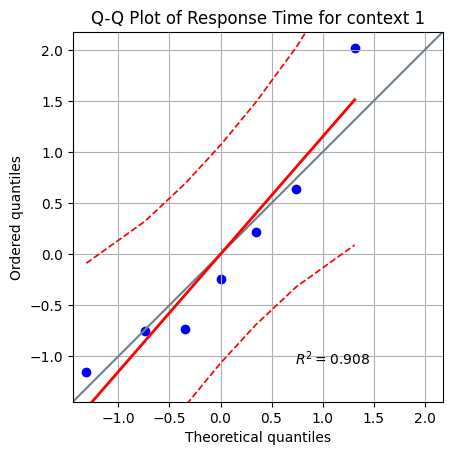

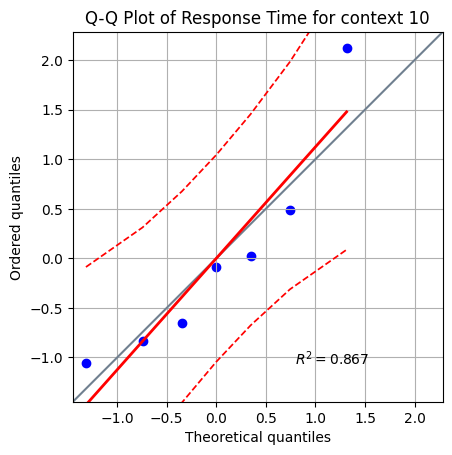

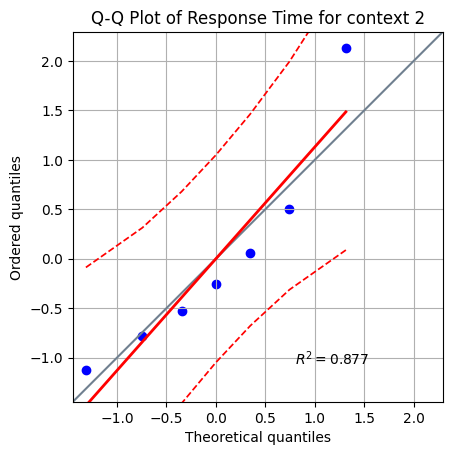

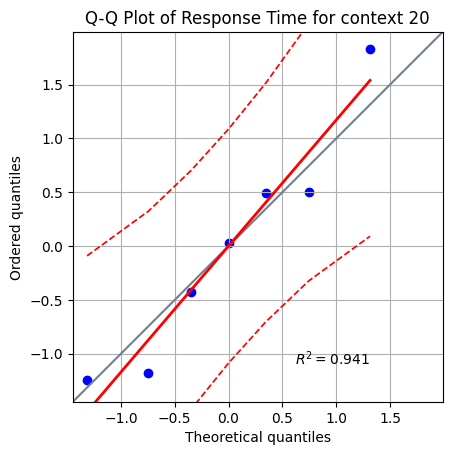

In [46]:
# Filter RTs
rt_df = df_gklab.loc[(df_gklab['context'] != '<NA>')]

# Get Mean Response Times by Contexts
mean_response_times_ctx = rt_df.groupby(['ID_info', 'context'])['response_time_info'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_response_times_ctx, dv='response_time_info', group='context')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_response_times_ctx, dv='response_time_info', group='context')
print(levene_results.round(3))

# Q-Q plots for each response category
ctx_categories = mean_response_times_ctx['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_response_times_ctx[mean_response_times_ctx['context'] == i]['response_time_info'], dist='norm')
    plt.title(f'Q-Q Plot of Response Time for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_response_times_ctx[mean_response_times_ctx['context'] == i]['response_time_info'], kde=True)
#     plt.title(f'Histogram of Response Time for context {i}')
#     plt.xlabel('Response Time')
#     plt.ylabel('Frequency')
#     plt.show()

In [47]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_response_times_ctx, dv='response_time_info', between='context', detailed=True)

# Print the ANOVA results
print(anova_results.round(3))
print("\n")

# Run post hoc tests if ANOVA is significant
if anova_results['p-unc'].values[0] < 0.05:
    posthoc_results = pg.pairwise_tests(data=mean_response_times_ctx, 
                                         dv='response_time_info', 
                                         between='context', 
                                         padjust='fdr_bh')
    print(posthoc_results.round(3))
    
else:
    print("No significant differences found; no post hoc analysis needed.")

    Source     SS  DF     MS      F  p-unc    np2
0  context  0.025   4  0.006  0.484  0.747  0.061
1   Within  0.386  30  0.013    NaN    NaN    NaN


No significant differences found; no post hoc analysis needed.


# Diference between error and success by Contexts during TMS pulse Analysis
- Normality test
- Wilcoxon signed rank test with Benjamini-Hochberg correction or T-Test with Benjamini/Hochberg Correction

                W      pval  normal
context                            
00       0.907905  0.381558    True
1        0.960341  0.821657    True
10       0.918979  0.461499    True
2        0.849355  0.121243    True
20       0.857416  0.143511    True


               W      pval  equal_var
levene  1.943392  0.128942       True


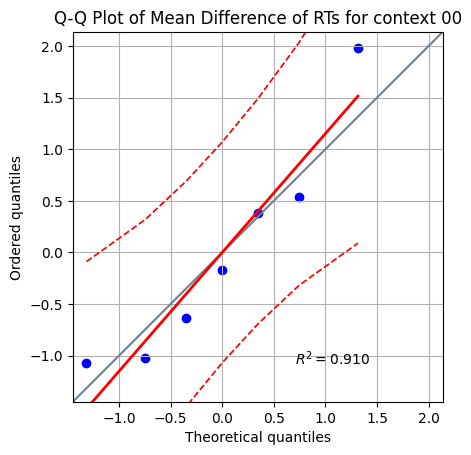

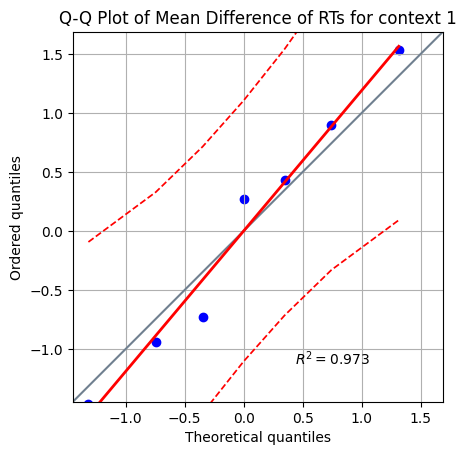

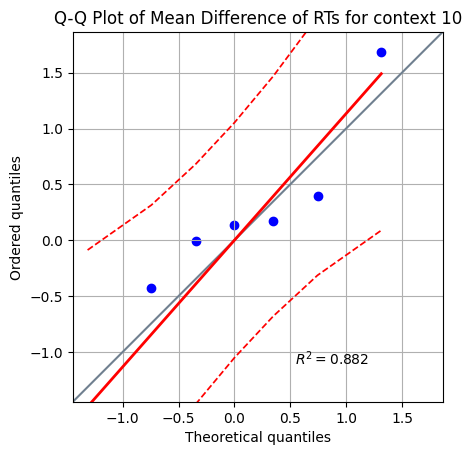

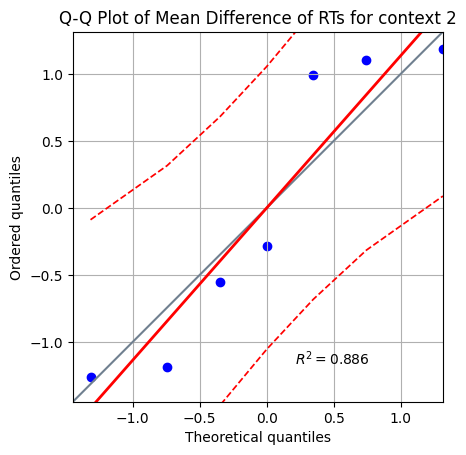

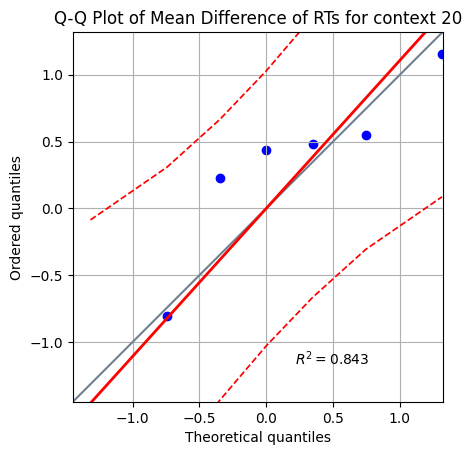

In [48]:
# Get Mean Response Times by Contexts and Plot   
mean_response_times_ctx_prevresult = rt_pulse_df.groupby(['ID_info', 'context', 'last_was_error'])['response_time_info'].mean().reset_index()

# Create a pivot table to calculate mean relMean_MEPpp_FDI for each combination
pivot_table = pd.pivot_table(mean_response_times_ctx_prevresult,
                            values='response_time_info',
                            index=['ID_info', 'context'],
                            columns='last_was_error',
                            aggfunc='mean',
                            fill_value=0)

# Calculate the difference between last_was_error categories
pivot_table['mean_difference'] = pivot_table[1] - pivot_table[0]

# Back to stack structure
stacked_df = pivot_table[['mean_difference']].reset_index()
stacked_df['reference'] = 0

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(stacked_df, dv='mean_difference', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(stacked_df, dv='mean_difference', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = stacked_df['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(stacked_df[stacked_df['context'] == i]['mean_difference'], dist='norm')
    plt.title(f'Q-Q Plot of Mean Difference of RTs for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(stacked_df[stacked_df['context'] == i]['mean_difference'], kde=True)
#     plt.title(f'Histogram of Response Times Mean Difference for context {i}')
#     plt.xlabel('Response Time Mean Difference')
#     plt.ylabel('Frequency')
#     plt.show()


In [49]:
### Using Wilcoxon signed rank test with Benjamini-Hochberg correction

from statsmodels.stats.multitest import multipletests

# Assuming stacked_df is your DataFrame
results_list = []
p_values = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    results = pg.wilcoxon(context_data['mean_difference'], context_data['reference'])
    
    # Collect p-value for Benjamini-Hochberg correction
    p_values.append(results['p-val'].iloc[0])
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'W': results['W-val'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'alternative': results['alternative'].iloc[0],
        'RBC': results['RBC'].iloc[0],
        'CLES': results['CLES'].iloc[0]
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini-Hochberg correction
_, adjusted_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = adjusted_p_values

results_df.round(3)

,context,W,p-val,alternative,RBC,CLES,adjusted_p-val
0,00,7.0,0.297,two-sided,-0.500,0.286,0.469
1,1,8.0,0.375,two-sided,0.429,0.571,0.469
2,10,8.0,0.375,two-sided,0.429,0.714,0.469
3,2,13.0,0.938,two-sided,-0.071,0.429,0.938
4,20,7.0,0.297,two-sided,0.500,0.714,0.469


In [50]:
### Using Paired T test and Benjamini/Hochberg correction

# Assuming stacked_df is your DataFrame
results_list = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    
    # Perform paired t-test using pingouin
    results = pg.ttest(context_data['mean_difference'], context_data['reference'], paired=True)
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'statistic': results['T'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'cohen-d': results['cohen-d'].iloc[0] # Effect size
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini/Hochberg correction using pingouin.multicomp
reject, pvals_corrected = pg.multicomp(results_df['p-val'], method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = pvals_corrected
results_df['reject'] = reject

results_df.round(3)


,context,statistic,p-val,cohen-d,adjusted_p-val,reject
0,00,-1.167,0.288,0.624,0.709,False
1,1,0.855,0.426,0.457,0.709,False
2,10,0.523,0.620,0.280,0.775,False
3,2,0.050,0.961,0.027,0.961,False
4,20,1.313,0.237,0.702,0.709,False


# Diference between error and success by Contexts without TMS pulse Analysis
- Normality test
- Wilcoxon signed rank test with Benjamini-Hochberg correction

                W      pval  normal
context                            
00       0.819460  0.063453    True
1        0.963658  0.849433    True
10       0.951615  0.744375    True
2        0.941886  0.655759    True
20       0.893147  0.291482    True


               W      pval  equal_var
levene  0.569135  0.686999       True


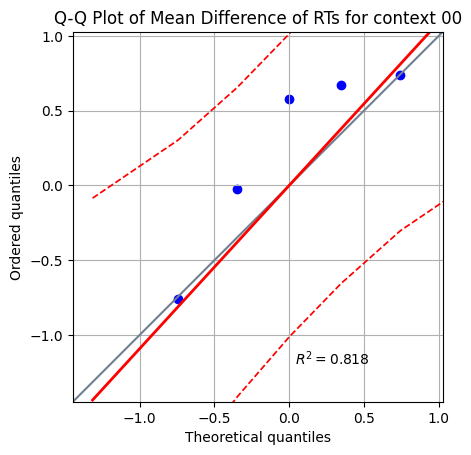

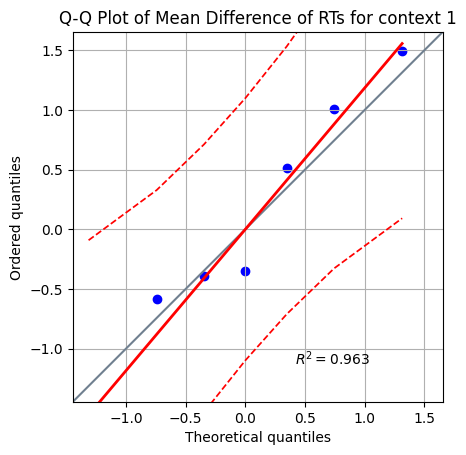

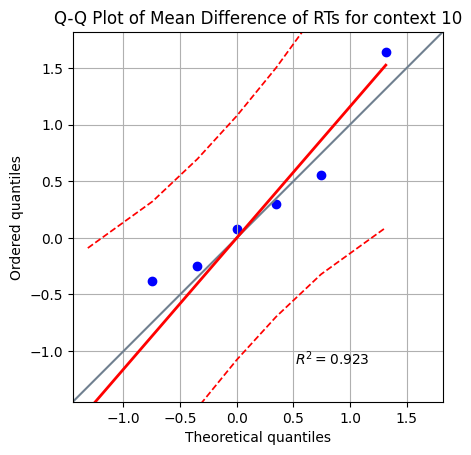

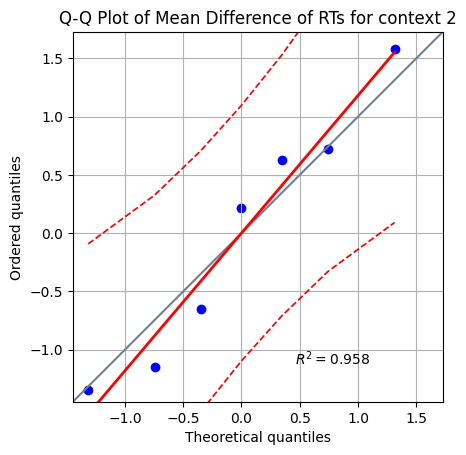

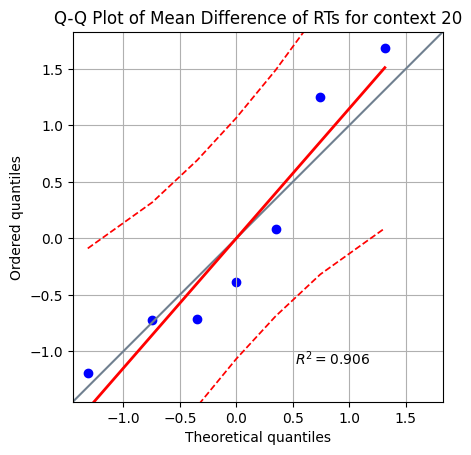

In [51]:
# Get Mean Response Times by Contexts and Plot   
mean_response_times_ctx_prevresult = rt_nopulse_df.groupby(['ID_info', 'context', 'last_was_error'])['response_time_info'].mean().reset_index()

# Create a pivot table to calculate mean relMean_MEPpp_FDI for each combination
pivot_table = pd.pivot_table(mean_response_times_ctx_prevresult,
                            values='response_time_info',
                            index=['ID_info', 'context'],
                            columns='last_was_error',
                            aggfunc='mean',
                            fill_value=0)

# Calculate the difference between last_was_error categories
pivot_table['mean_difference'] = pivot_table[1] - pivot_table[0]

# Back to stack structure
stacked_df = pivot_table[['mean_difference']].reset_index()
stacked_df['reference'] = 0

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(stacked_df, dv='mean_difference', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(stacked_df, dv='mean_difference', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = stacked_df['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(stacked_df[stacked_df['context'] == i]['mean_difference'], dist='norm')
    plt.title(f'Q-Q Plot of Mean Difference of RTs for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(stacked_df[stacked_df['context'] == i]['mean_difference'], kde=True)
#     plt.title(f'Histogram of Response Times Mean Difference for context {i}')
#     plt.xlabel('Response Time Mean Difference')
#     plt.ylabel('Frequency')
#     plt.show()


In [52]:
### Using Wilcoxon signed rank test with Benjamini-Hochberg correction

from statsmodels.stats.multitest import multipletests

# Assuming stacked_df is your DataFrame
results_list = []
p_values = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    results = pg.wilcoxon(context_data['mean_difference'], context_data['reference'])
    
    # Collect p-value for Benjamini-Hochberg correction
    p_values.append(results['p-val'].iloc[0])
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'W': results['W-val'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'alternative': results['alternative'].iloc[0],
        'RBC': results['RBC'].iloc[0],
        'CLES': results['CLES'].iloc[0]
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini-Hochberg correction
_, adjusted_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = adjusted_p_values

results_df.round(3)

,context,W,p-val,alternative,RBC,CLES,adjusted_p-val
0,00,11.0,0.688,two-sided,-0.214,0.571,0.938
1,1,12.0,0.812,two-sided,0.143,0.429,0.938
2,10,11.0,0.688,two-sided,-0.214,0.429,0.938
3,2,10.0,0.578,two-sided,-0.286,0.429,0.938
4,20,13.0,0.938,two-sided,0.071,0.429,0.938


In [53]:
### Using Paired T test and Benjamini/Hochberg correction

# Assuming stacked_df is your DataFrame
results_list = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    
    # Perform paired t-test using pingouin
    results = pg.ttest(context_data['mean_difference'], context_data['reference'], paired=True)
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'statistic': results['T'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'cohen-d': results['cohen-d'].iloc[0] # Effect size
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini/Hochberg correction using pingouin.multicomp
reject, pvals_corrected = pg.multicomp(results_df['p-val'], method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = pvals_corrected
results_df['reject'] = reject

results_df.round(3)

,context,statistic,p-val,cohen-d,adjusted_p-val,reject
0,00,-0.994,0.358,0.532,0.703,False
1,1,0.581,0.582,0.311,0.703,False
2,10,-0.401,0.703,0.214,0.703,False
3,2,-0.606,0.567,0.324,0.703,False
4,20,0.691,0.516,0.369,0.703,False


# Diference between error and success by Contexts with all RTs (n = 1200)
- Normality test
- ANOVA

                W      pval  normal
context                            
00       0.959259  0.812351    True
1        0.962644  0.841077    True
10       0.781178  0.026550   False
2        0.972301  0.914514    True
20       0.925356  0.512134    True


               W      pval  equal_var
levene  0.930829  0.459316       True


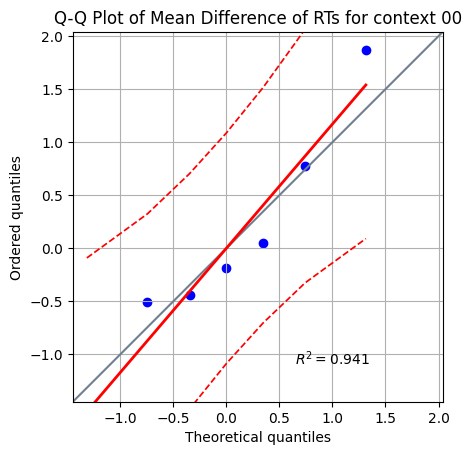

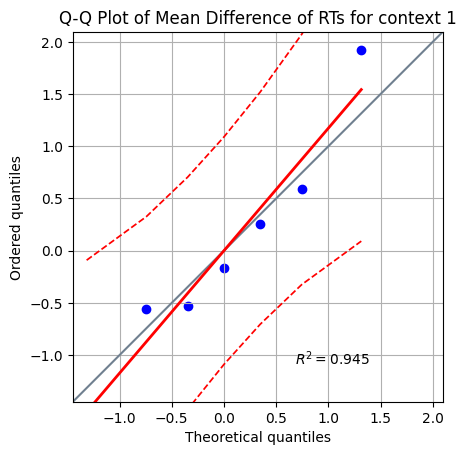

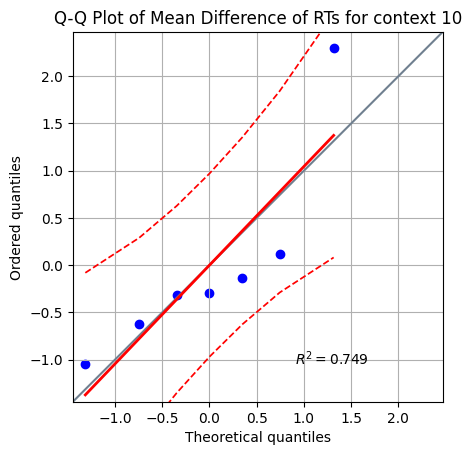

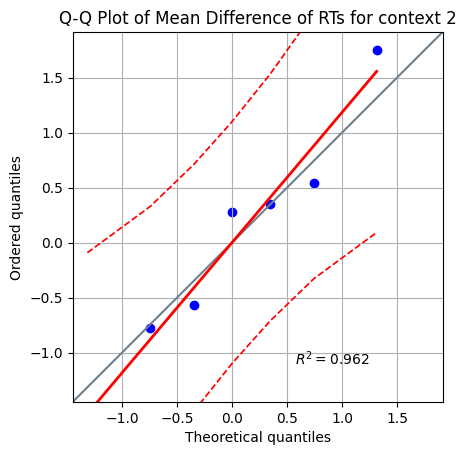

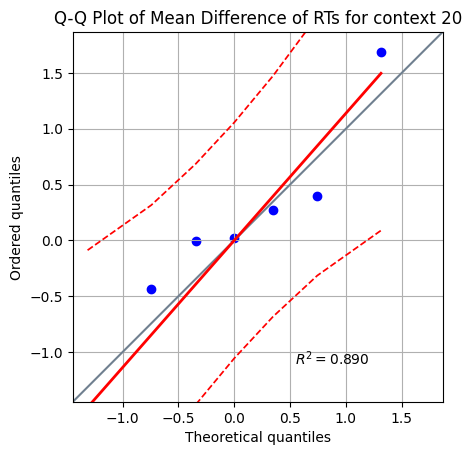

In [54]:
# Get Mean Response Times by Contexts and Plot   
mean_all_response_times_ctx_prevresult = rt_df.groupby(['ID_info', 'context', 'last_was_error'])['response_time_info'].mean().reset_index()

# Create a pivot table to calculate mean relMean_MEPpp_FDI for each combination
pivot_table = pd.pivot_table(mean_all_response_times_ctx_prevresult,
                            values='response_time_info',
                            index=['ID_info', 'context'],
                            columns='last_was_error',
                            aggfunc='mean',
                            fill_value=0)

# Calculate the difference between last_was_error categories
pivot_table['mean_difference'] = pivot_table[1] - pivot_table[0]

# Back to stack structure
stacked_df = pivot_table[['mean_difference']].reset_index()
stacked_df['reference'] = 0

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(stacked_df, dv='mean_difference', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(stacked_df, dv='mean_difference', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = stacked_df['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(stacked_df[stacked_df['context'] == i]['mean_difference'], dist='norm')
    plt.title(f'Q-Q Plot of Mean Difference of RTs for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(stacked_df[stacked_df['context'] == i]['mean_difference'], kde=True)
#     plt.title(f'Histogram of Response Times Mean Difference for context {i}')
#     plt.xlabel('Response Time Mean Difference')
#     plt.ylabel('Frequency')
#     plt.show()

In [55]:
### Using Wilcoxon signed rank test with Benjamini-Hochberg correction

from statsmodels.stats.multitest import multipletests

# Assuming stacked_df is your DataFrame
results_list = []
p_values = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    results = pg.wilcoxon(context_data['mean_difference'], context_data['reference'])
    
    # Collect p-value for Benjamini-Hochberg correction
    p_values.append(results['p-val'].iloc[0])
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'W': results['W-val'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'alternative': results['alternative'].iloc[0],
        'RBC': results['RBC'].iloc[0],
        'CLES': results['CLES'].iloc[0]
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini-Hochberg correction
_, adjusted_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = adjusted_p_values

results_df.round(3)

,context,W,p-val,alternative,RBC,CLES,adjusted_p-val
0,00,7.0,0.297,two-sided,-0.500,0.286,0.742
1,1,9.0,0.469,two-sided,0.357,0.571,0.781
2,10,14.0,1.000,two-sided,0.000,0.429,1.000
3,2,12.0,0.812,two-sided,-0.143,0.571,1.000
4,20,4.0,0.109,two-sided,0.714,0.857,0.547


In [56]:
### Using Paired T test and Benjamini/Hochberg correction

# Assuming stacked_df is your DataFrame
results_list = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    
    # Perform paired t-test using pingouin
    results = pg.ttest(context_data['mean_difference'], context_data['reference'], paired=True)
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'statistic': results['T'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'cohen-d': results['cohen-d'].iloc[0] # Effect size
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini/Hochberg correction using pingouin.multicomp
reject, pvals_corrected = pg.multicomp(results_df['p-val'], method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = pvals_corrected
results_df['reject'] = reject

results_df.round(3)

,context,statistic,p-val,cohen-d,adjusted_p-val,reject
0,00,-1.159,0.291,0.619,0.662,False
1,1,0.912,0.397,0.487,0.662,False
2,10,0.565,0.593,0.302,0.741,False
3,2,-0.230,0.826,0.123,0.826,False
4,20,2.080,0.083,1.112,0.414,False


# MEP differences between blocks
- Normality test
- Kruskal-Wallis test and Dunn's post hoc with Benjamini/Hochberg correction 

                W   pval  normal
block_info                      
2.0         0.935  0.590    True
4.0         0.914  0.426    True
6.0         0.925  0.507    True


            W   pval  equal_var
levene  0.414  0.667       True


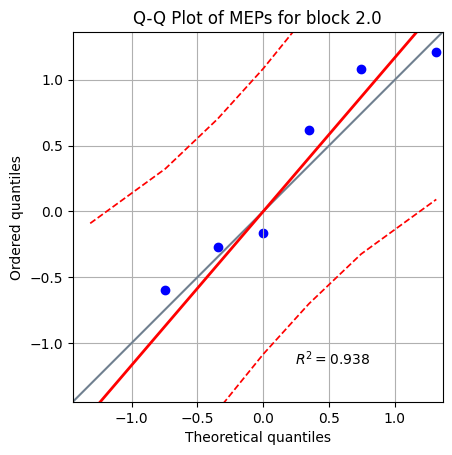

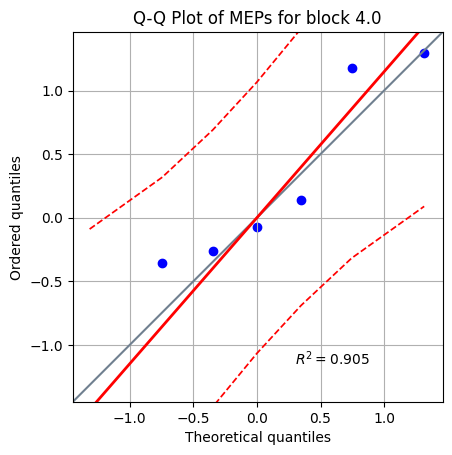

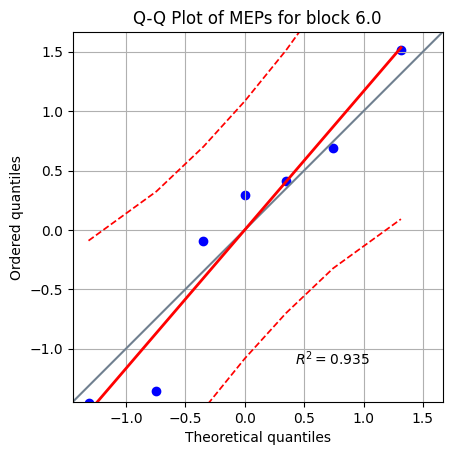

In [57]:
# Filter MEPs during pulses
meps_blocks_df = df_gklab.loc[(df_gklab['tms_pulse'] == 'Pulse')]

# Calculate mean FDI MEPs grouped by ID_info and block_info
mean_FDImeps_by_blocks = meps_blocks_df.groupby(['ID_info', 'block_info'])['relMean_MEPpp_FDI'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_FDImeps_by_blocks, dv='relMean_MEPpp_FDI', group='block_info')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_FDImeps_by_blocks, dv='relMean_MEPpp_FDI', group='block_info')
print(levene_results.round(3))

# Q-Q plots for each MEP block
block_categories = mean_FDImeps_by_blocks['block_info'].unique()
for i in block_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_FDImeps_by_blocks[mean_FDImeps_by_blocks['block_info'] == i]['relMean_MEPpp_FDI'], dist='norm')
    plt.title(f'Q-Q Plot of MEPs for block {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in block_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_FDImeps_by_blocks[mean_FDImeps_by_blocks['block_info'] == i]['relMean_MEPpp_FDI'], kde=True)
#     plt.title(f'Histogram of FDI MEPs for block {i}')
#     plt.xlabel('FDI MEPs')
#     plt.ylabel('Frequency')
#     plt.show()

In [58]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_FDImeps_by_blocks, 
                          dv='relMean_MEPpp_FDI', 
                          between='block_info')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_FDImeps_by_blocks['block_info'].nunique()
n = len(mean_FDImeps_by_blocks)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_response_times_by_blocks, val_col='relMean_MEPpp_FDI', group_col='block_info', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results)
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
             Source  ddof1      H  p-unc
Kruskal  block_info      2  1.544  0.462

Eta ao quadrado adaptado (η²) para Kruskal-Wallis: -0.0254

No significant differences found; no post hoc analysis needed.


# FDI MEP difference between responses

                   W   pval  normal
response_info                      
0.0            0.751  0.013   False
1.0            0.886  0.252    True
2.0            0.860  0.150    True


            W   pval  equal_var
levene  0.778  0.474       True


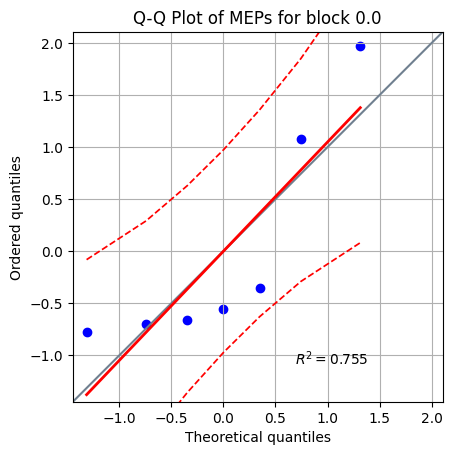

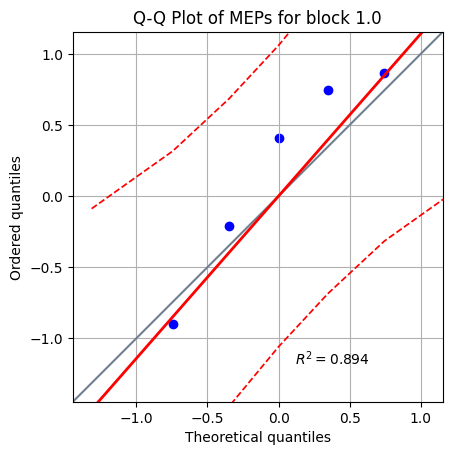

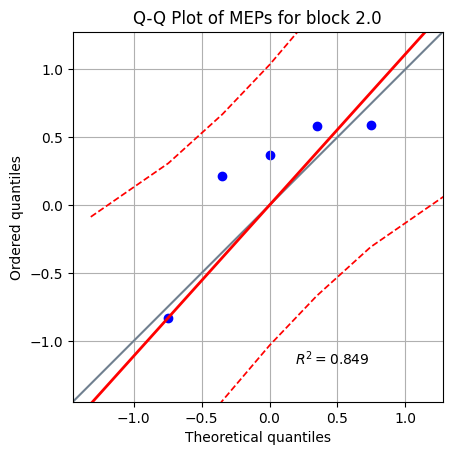

In [59]:
# Calculate mean FDI MEPs grouped by ID_info and response_info
mean_FDImeps_by_response = meps_blocks_df.groupby(['ID_info', 'response_info'])['relMean_MEPpp_FDI'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_FDImeps_by_response, dv='relMean_MEPpp_FDI', group='response_info')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_FDImeps_by_response, dv='relMean_MEPpp_FDI', group='response_info')
print(levene_results.round(3))

# Q-Q plots for each MEP block
block_categories = mean_FDImeps_by_response['response_info'].unique()
for i in block_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_FDImeps_by_response[mean_FDImeps_by_response['response_info'] == i]['relMean_MEPpp_FDI'], dist='norm')
    plt.title(f'Q-Q Plot of MEPs for block {i}')
    plt.grid(True)
    plt.show()

In [60]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_FDImeps_by_response, 
                          dv='relMean_MEPpp_FDI', 
                          between='response_info')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_FDImeps_by_response['response_info'].nunique()
n = len(mean_FDImeps_by_response)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_FDImeps_by_response, val_col='relMean_MEPpp_FDI', group_col='response_info', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results)
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
                Source  ddof1      H  p-unc
Kruskal  response_info      2  1.989   0.37

Eta ao quadrado adaptado (η²) para Kruskal-Wallis: -0.0006

No significant differences found; no post hoc analysis needed.


# FDI MEP differences by contexts
- Normality test
- Kruskal-Wallis test and Dunn's post hoc with Benjamini/Hochberg correction 

                W      pval  normal
context                            
00       0.810246  0.051653    True
1        0.788769  0.031661   False
10       0.865782  0.170432    True
2        0.828211  0.076950    True
20       0.936309  0.605729    True


               W      pval  equal_var
levene  1.044085  0.401034       True


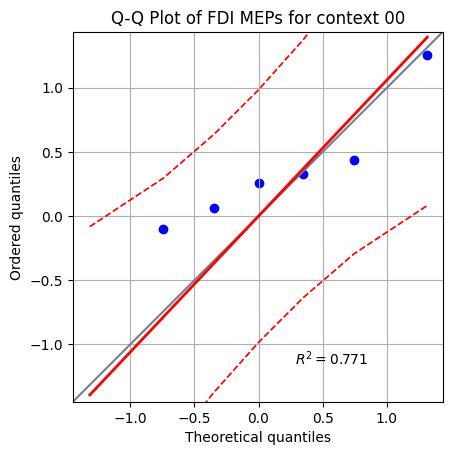

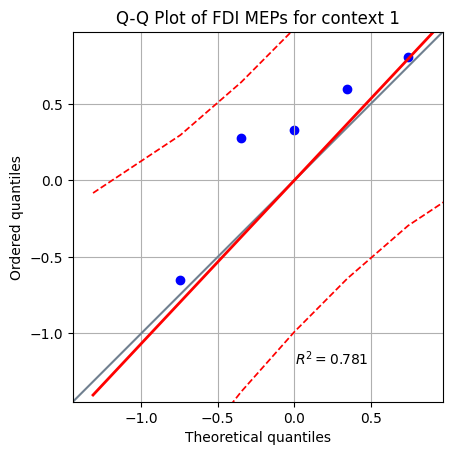

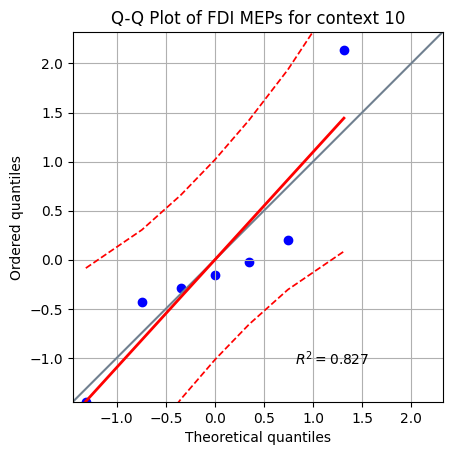

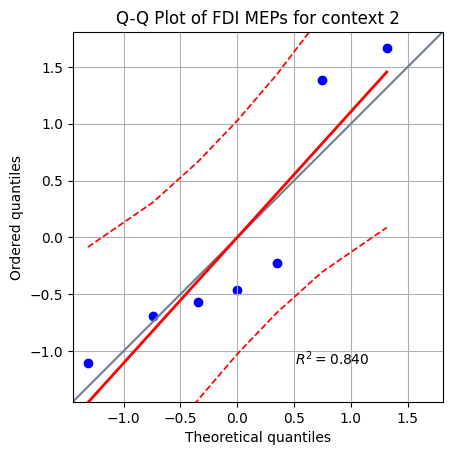

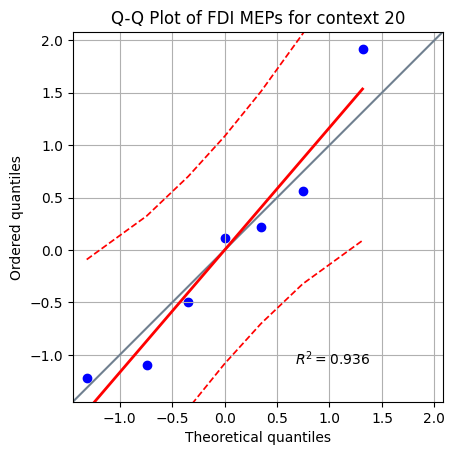

In [61]:
# Filter MEPs during pulses
meps_blocks_df = df_gklab.loc[(df_gklab['tms_pulse'] == 'Pulse') & (df_gklab['context'] != '<NA>')]

# Get Mean FDI MEPs relative to mean by Contexts    
mean_relmFDImepsmean_ctx = meps_blocks_df.groupby(['ID_info', 'context'])['relMean_MEPpp_FDI'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_relmFDImepsmean_ctx, dv='relMean_MEPpp_FDI', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_relmFDImepsmean_ctx, dv='relMean_MEPpp_FDI', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = mean_relmFDImepsmean_ctx['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_relmFDImepsmean_ctx[mean_relmFDImepsmean_ctx['context'] == i]['relMean_MEPpp_FDI'], dist='norm')
    plt.title(f'Q-Q Plot of FDI MEPs for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_relmFDImepsmean_ctx[mean_relmFDImepsmean_ctx['context'] == i]['relMean_MEPpp_FDI'], kde=True)
#     plt.title(f'Histogram of FDI MEPs for context {i}')
#     plt.xlabel('FDI MEPs')
#     plt.ylabel('Frequency')
#     plt.show()

In [ ]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_relmFDImepsmean_ctx, dv='relMean_MEPpp_FDI', between='context', detailed=True)

# Print the ANOVA results
print(anova_results.round(3))
print("\n")

# Perform post hoc tests with Benjamini/Hochberg correction
posthoc_results = pg.pairwise_tests(data=mean_relmFDImepsmean_ctx, 
                                     dv='relMean_MEPpp_FDI', 
                                     between='context', 
                                     padjust='fdr_bh')

# Print the post hoc results
print(posthoc_results.round(3))

In [62]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_relmFDImepsmean_ctx, 
                          dv='relMean_MEPpp_FDI', 
                          between='context')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_relmFDImepsmean_ctx['context'].nunique()
n = len(mean_relmFDImepsmean_ctx)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_relmFDImepsmean_ctx, val_col='relMean_MEPpp_FDI', group_col='context', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results)
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
          Source  ddof1      H  p-unc
Kruskal  context      4  1.995  0.737

Eta ao quadrado adaptado (η²) para Kruskal-Wallis: -0.0668

No significant differences found; no post hoc analysis needed.


# FDS MEP difference between responses

                   W   pval  normal
response_info                      
0.0            0.941  0.649    True
1.0            0.839  0.097    True
2.0            0.956  0.780    True


            W   pval  equal_var
levene  1.371  0.279       True


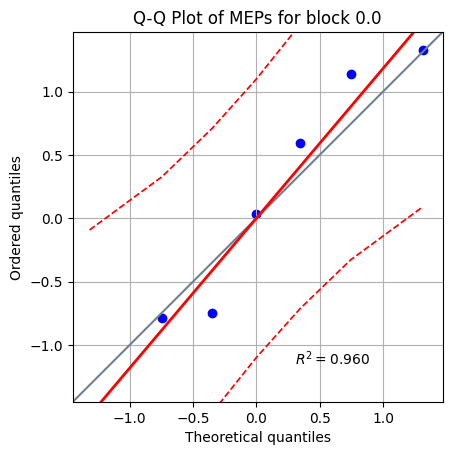

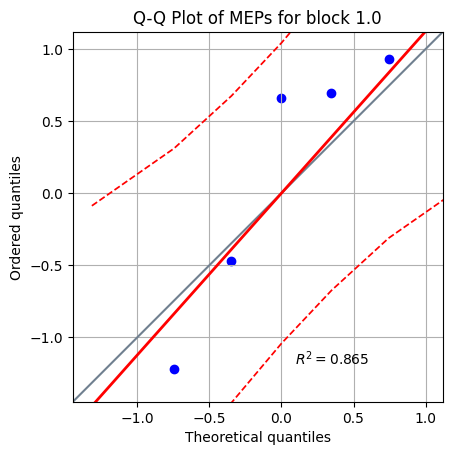

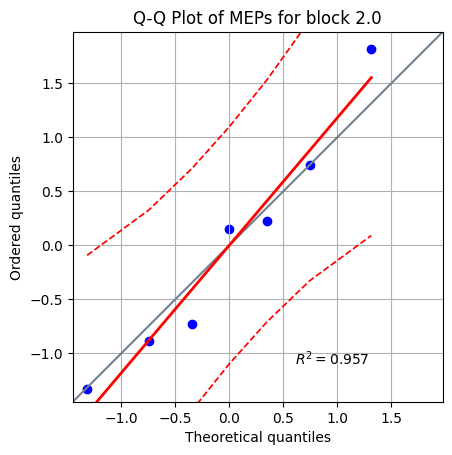

In [63]:
# Calculate mean FDS MEPs grouped by ID_info and response_info
mean_FDSmeps_by_response = meps_blocks_df.groupby(['ID_info', 'response_info'])['relMean_MEPpp_FDS'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_FDSmeps_by_response, dv='relMean_MEPpp_FDS', group='response_info')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_FDSmeps_by_response, dv='relMean_MEPpp_FDS', group='response_info')
print(levene_results.round(3))

# Q-Q plots for each MEP block
block_categories = mean_FDSmeps_by_response['response_info'].unique()
for i in block_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_FDSmeps_by_response[mean_FDSmeps_by_response['response_info'] == i]['relMean_MEPpp_FDS'], dist='norm')
    plt.title(f'Q-Q Plot of MEPs for block {i}')
    plt.grid(True)
    plt.show()

In [64]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_FDSmeps_by_response, 
                          dv='relMean_MEPpp_FDS', 
                          between='response_info')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_FDSmeps_by_response['response_info'].nunique()
n = len(mean_FDSmeps_by_response)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_FDSmeps_by_response, val_col='relMean_MEPpp_FDS', group_col='response_info', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results)
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
                Source  ddof1       H  p-unc
Kruskal  response_info      2  13.677  0.001

Eta ao quadrado adaptado (η²) para Kruskal-Wallis: 0.6487

Dunn's Post Hoc Test Results:
          0.0       1.0       2.0
0.0  1.000000  0.575514  0.005855
1.0  0.575514  1.000000  0.001708
2.0  0.005855  0.001708  1.000000


## Analysing FDS MEPs by context

                W      pval  normal
context                            
00       0.942828  0.664306    True
1        0.926054  0.517865    True
10       0.922996  0.493029    True
2        0.957838  0.799989    True
20       0.984616  0.978852    True


               W      pval  equal_var
levene  0.819867  0.522758       True


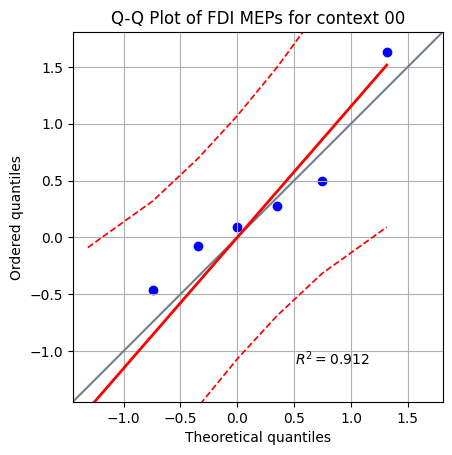

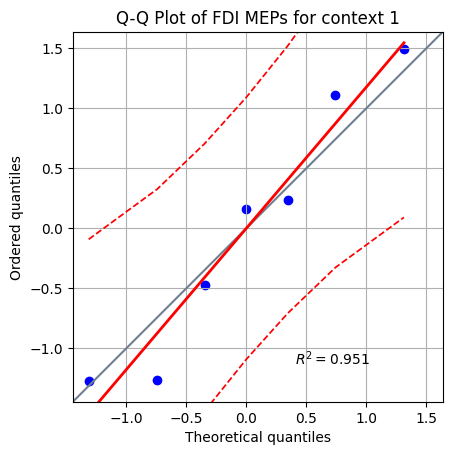

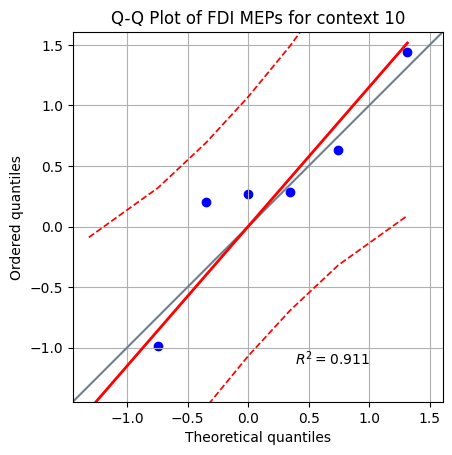

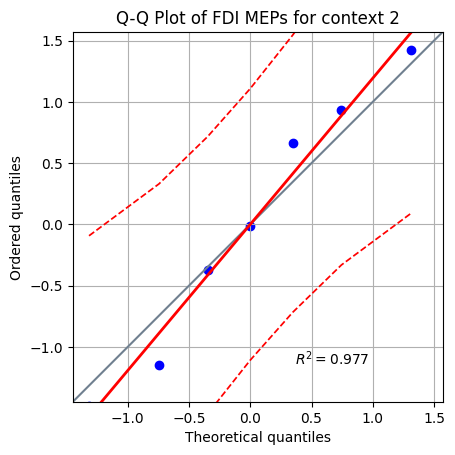

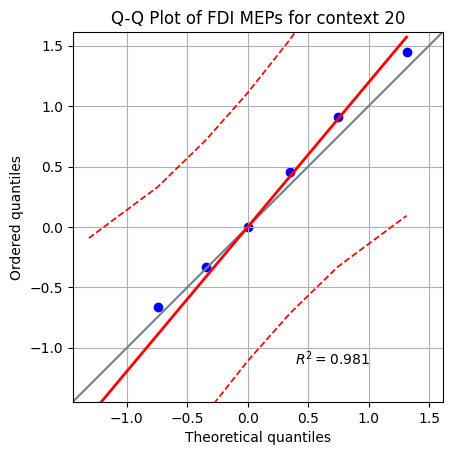

In [65]:
# Get Mean FDS MEPs relative to mean by Contexts    
mean_relmFDSmepsmean_ctx = meps_blocks_df.groupby(['ID_info', 'context'])['relMean_MEPpp_FDS'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_relmFDSmepsmean_ctx, dv='relMean_MEPpp_FDS', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_relmFDSmepsmean_ctx, dv='relMean_MEPpp_FDS', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = mean_relmFDSmepsmean_ctx['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_relmFDSmepsmean_ctx[mean_relmFDSmepsmean_ctx['context'] == i]['relMean_MEPpp_FDS'], dist='norm')
    plt.title(f'Q-Q Plot of FDI MEPs for context {i}')
    plt.grid(True)
    plt.show()

In [66]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_relmFDSmepsmean_ctx, dv='relMean_MEPpp_FDS', between='context', detailed=True)

# Print the ANOVA results
print(anova_results.round(3))
print("\n")

# Perform post hoc tests with Benjamini/Hochberg correction
posthoc_results = pg.pairwise_tests(data=mean_relmFDSmepsmean_ctx, 
                                     dv='relMean_MEPpp_FDS', 
                                     between='context', 
                                     padjust='fdr_bh')

# Print the post hoc results
print(posthoc_results.round(3))

    Source     SS  DF     MS      F  p-unc  np2
0  context  0.108   4  0.027  7.503    0.0  0.5
1   Within  0.108  30  0.004    NaN    NaN  NaN


  Contrast   A   B  Paired  Parametric      T   dof alternative  p-unc  \
0  context  00   1   False        True -4.127  12.0   two-sided  0.001   
1  context  00  10   False        True  0.788  12.0   two-sided  0.446   
2  context  00   2   False        True  0.220  12.0   two-sided  0.830   
3  context  00  20   False        True  0.957  12.0   two-sided  0.357   
4  context   1  10   False        True  4.139  12.0   two-sided  0.001   
5  context   1   2   False        True  4.040  12.0   two-sided  0.002   
6  context   1  20   False        True  3.939  12.0   two-sided  0.002   
7  context  10   2   False        True -0.560  12.0   two-sided  0.586   
8  context  10  20   False        True  0.257  12.0   two-sided  0.802   
9  context   2  20   False        True  0.760  12.0   two-sided  0.462   

   p-corr p-adjust    BF10  hedges  
0 

In [ ]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_relmFDSmepsmean_ctx, 
                          dv='relMean_MEPpp_FDS', 
                          between='context')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_relmFDSmepsmean_ctx['context'].nunique()
n = len(mean_relmFDSmepsmean_ctx)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_relmFDSmepsmean_ctx, val_col='relMean_MEPpp_FDS', group_col='context', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results)
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

# MEP diference between error and success by Contexts
- Normality test
- Wilcoxon signed rank test with Benjamini-Hochberg correction or T-Test with Benjamini/Hochberg Correction

                W      pval  normal
context                            
00       0.839898  0.099142    True
1        0.918634  0.458858    True
10       0.968247  0.885544    True
2        0.882654  0.238494    True
20       0.954595  0.771241    True


               W      pval  equal_var
levene  0.648642  0.632238       True


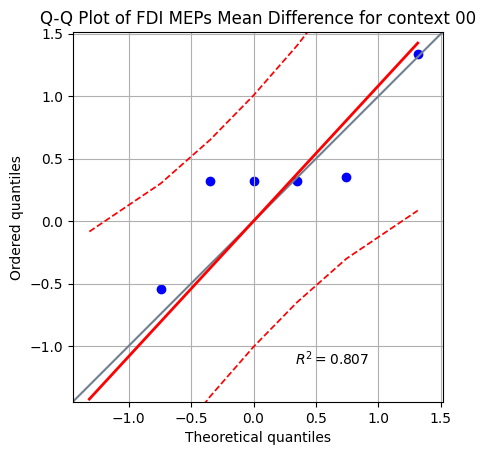

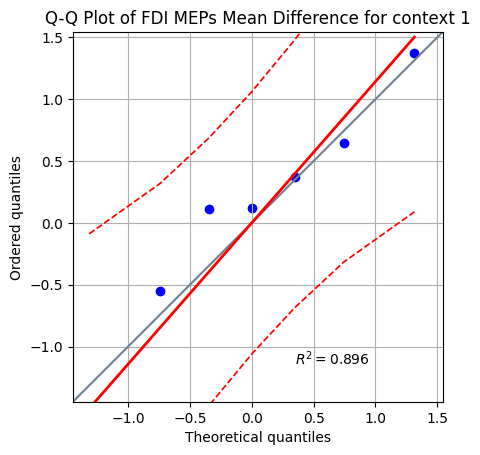

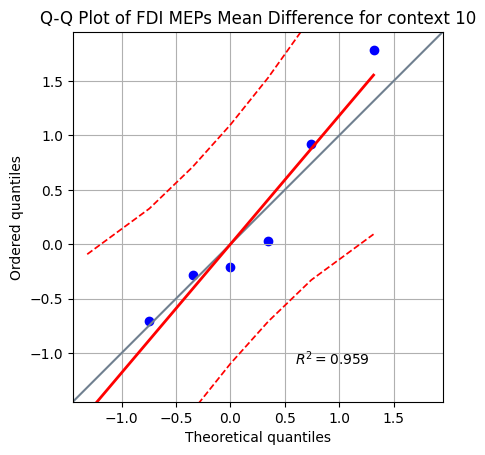

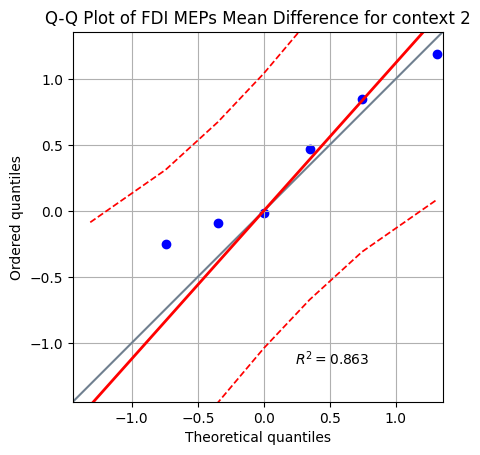

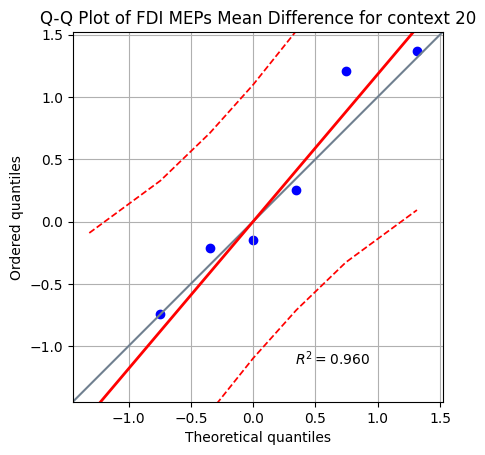

In [67]:
# Get Mean FDI MEPs by Contexts and Previous Result and Plot    
mean_FDImeps_ctx_prevresult = meps_blocks_df.groupby(['ID_info', 'context', 'last_was_error'])['relMean_MEPpp_FDI'].mean().reset_index()

# Create a pivot table to calculate mean relMean_MEPpp_FDI for each combination
pivot_table = pd.pivot_table(mean_FDImeps_ctx_prevresult,
                            values='relMean_MEPpp_FDI',
                            index=['ID_info', 'context'],
                            columns='last_was_error',
                            aggfunc='mean',
                            fill_value=0)

# Calculate the difference between last_was_error categories
pivot_table['mean_difference'] = pivot_table[1] - pivot_table[0]

# Back to stack structure
stacked_df = pivot_table[['mean_difference']].reset_index()
stacked_df['reference'] = 0

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(stacked_df, dv='mean_difference', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(stacked_df, dv='mean_difference', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = stacked_df['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(stacked_df[stacked_df['context'] == i]['mean_difference'], dist='norm')
    plt.title(f'Q-Q Plot of FDI MEPs Mean Difference for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(stacked_df[stacked_df['context'] == i]['mean_difference'], kde=True)
#     plt.title(f'Histogram of FDI MEPs Mean Difference for context {i}')
#     plt.xlabel('FDI MEPs Mean Difference')
#     plt.ylabel('Frequency')
#     plt.show()

In [68]:
### Using Paired T test and Benjamini/Hochberg correction

# Assuming stacked_df is your DataFrame
results_list = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    
    # Perform paired t-test using pingouin
    results = pg.ttest(context_data['mean_difference'], context_data['reference'], paired=True)
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'statistic': results['T'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'cohen-d': results['cohen-d'].iloc[0] # Effect size
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini/Hochberg correction using pingouin.multicomp
reject, pvals_corrected = pg.multicomp(results_df['p-val'], method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = pvals_corrected
results_df['reject'] = reject

results_df

,context,statistic,p-val,cohen-d,adjusted_p-val,reject
0,00,-0.381156,0.716219,0.203737,0.895274,False
1,1,0.572049,0.588064,0.305773,0.895274,False
2,10,-0.530244,0.614984,0.283427,0.895274,False
3,2,-0.072921,0.944239,0.038978,0.944239,False
4,20,-0.492131,0.640113,0.263055,0.895274,False
